# DATA2 -  RF - baseline - Feature Permutation

## Features
1. 'AGE'


1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'


1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'


1. 'CATANIMSC\_neuro'


1. 'LRHHC\_n\_long'


1. 'Apoe4_'


1. 'Gender\_num\_'
1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'


**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.03):

    - ver. 0.03 (2021.07.30)
        - column renaming function (in mci_utils).
    - ver. 0.02 (2021.06.28)
        - feature perumtation function from scratch,
        - perumation averaging over k repetitions.
   
   *Created: 2021.06.23 / Updated: 2021.09.14*
   
---

#### IMPORTS

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, SVG, Image
from eli5.sklearn import PermutationImportance

In [4]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
import mci_permutation as mperm

In [5]:
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [6]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20210420' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [7]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: Ingrids-MacBook-Air-3.local
Operating system: Darwin, 64bit

Python path: /Users/ingridrye/opt/miniconda3/envs/mci/bin/python
Python version: 3.7.10 (default, Feb 26 2021, 10:16:00) 
[Clang 10.0.0 ]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.3
10,matplotlib,3.3.4
13,numpy,1.20.1
15,pandas,1.2.4
16,pdpbox,0.2.1
20,scipy,1.6.2
21,seaborn,0.11.1
23,sklearn,0.24.2
24,statsmodels,


---

##  FEATURES TO FEED A MODEL - THESE GLOBAL VARIABLES MUST BE UPDATED IN EACH NOTEBOOK SEPARATELY!!! 

In [29]:
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'LRHHC_n_long', 'Subgroup_', 'Subgroup_num_', 'Usage_',
           'Gender_num_', 'PTGENDER'
           ]


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.111_RF-bl-permutation'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]


FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.111_RF-bl'

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 10

# display all stuff
VERBOSE = True

---

## LOAD BASELINE FILE AND RESTRICT COLUMN RANGE TO SELECTED FEATURES ONLY (FEATURES + Subgroup\_ x2 + Usage\_)

In [30]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	13


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [31]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease forfurther manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [32]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [33]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-long-_')

Total number of columns: 13



,adni (#3),neuro (#5),long (#1),ours (#4)
0,AGE,AVDEL30MIN_neuro,LRHHC_n_long,Gender_num_
1,PTGENDER,AVDELTOT_neuro,,Subgroup_
2,RAVLT_immediate,CATANIMSC_neuro,,Subgroup_num_
3,,TRAASCOR_neuro,,Usage_
4,,TRABSCOR_neuro,,


---

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [34]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 543
 - Test set: 141


---

# RANDOM FORESTS CLASSIFICATION

---

## CREATE X AND y

In [35]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

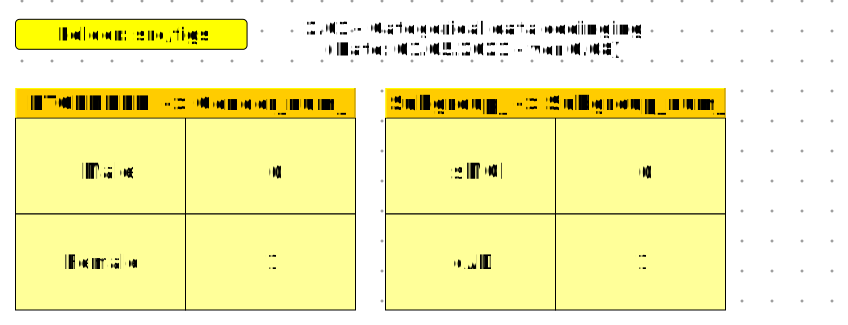

In [36]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

---

## REMOVE `SUBGROUP_`, `Subgroup_num_` and `Usage_` COLUMNS FROM THE TRAIN & TEST SETS

In [37]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER


In [38]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'LRHHC_n_long']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'LRHHC_n_long']



---

# LOAD GRID SEARCH RESULTS FROM A FILE

In [39]:
# A filename of the the whole gridsearch structure
# LOAD A GS RESULT FORM A 3.01_RF-bl-neuropsych-MRI-FAQ-GDS by AV FILE!!!!
file_name_prefix_ext =  FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
grid = joblib.load(file_name_prefix_path)     
    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('\nBest params are stored in the variable: BEST_PARAMS')
BEST_PARAMS = grid.best_params_

GridSearch parameters loaded from a file:
		/Users/ingridrye/123/results/20210420/3.111_RF-bl-GS-model.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ingridrye/123/results/20210420/3.111_RF-bl-GS-model.pkl'

---

# TEST SET

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [26]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.683
0.683


## `TEST SET` SCORES (F1, ACCURACY, RECALL, PRECISION)

In [27]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.662
ACC: 0.683
RECALL: 0.662
PREC: 0.662


## CONFUSIOM MATRIX

#### PREDICTIONS

In [28]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=False, results_dir=RESULTS_DIR)


Subjects in the predictions table: 139



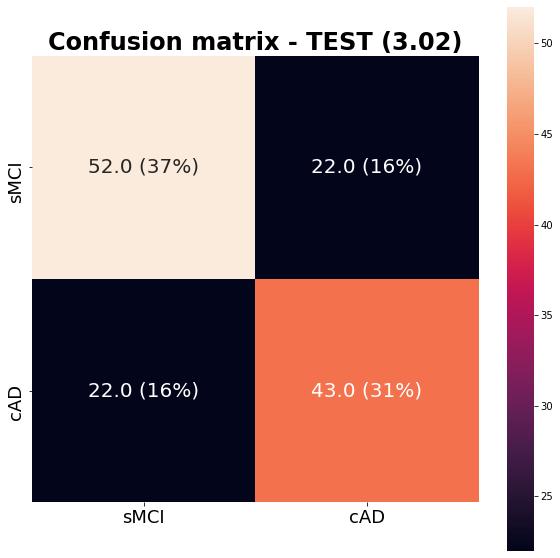

In [29]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matrix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=False, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [30]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

RAVLT_immediate     0.246132
LRHHC_n_long        0.195135
AVDEL30MIN_neuro    0.149581
AVDELTOT_neuro      0.076739
TRABSCOR_neuro      0.067656
AGE                 0.064035
ANARTERR_neuro      0.063566
TRAASCOR_neuro      0.060256
CATANIMSC_neuro     0.054789
GDTOTAL_gds         0.022111


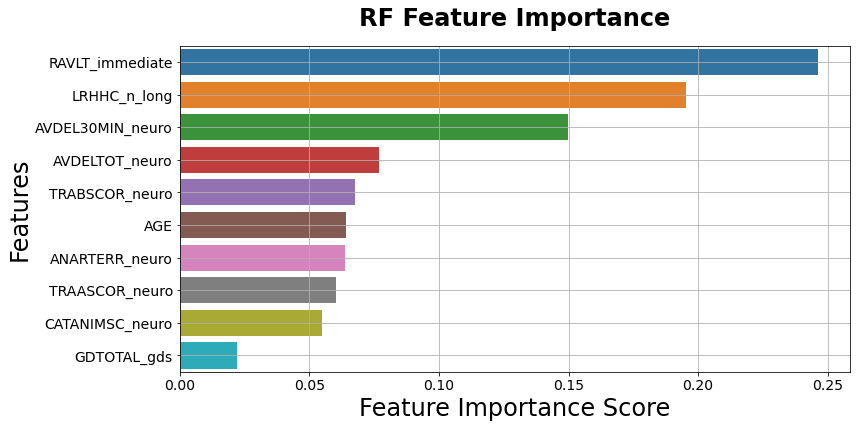

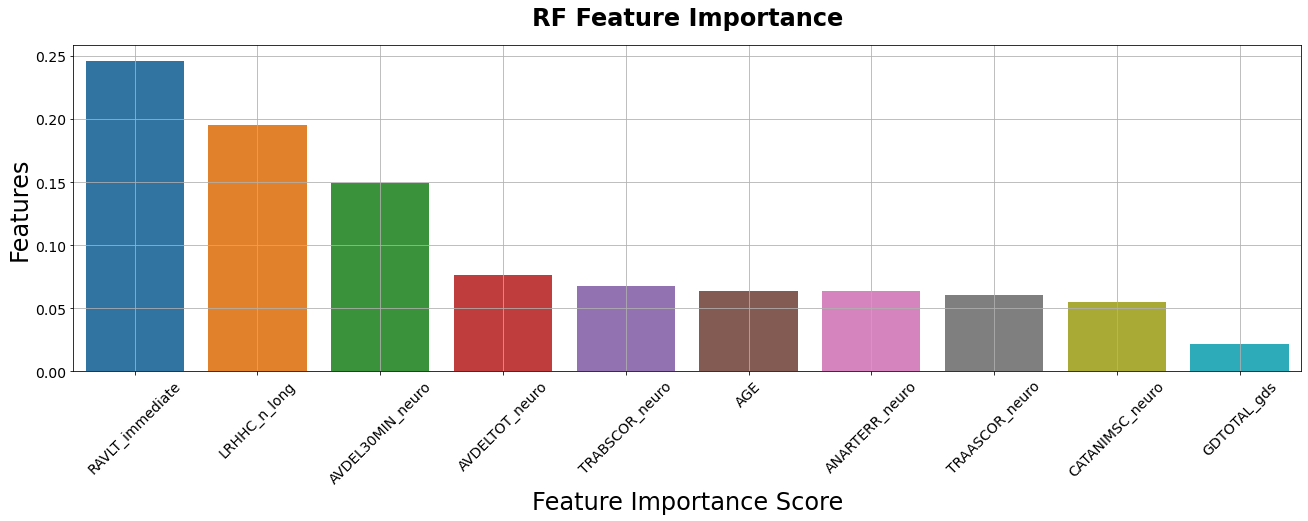

In [31]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR, save=False)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR, save=False)

---

## CORELATION (OPTIONAL)

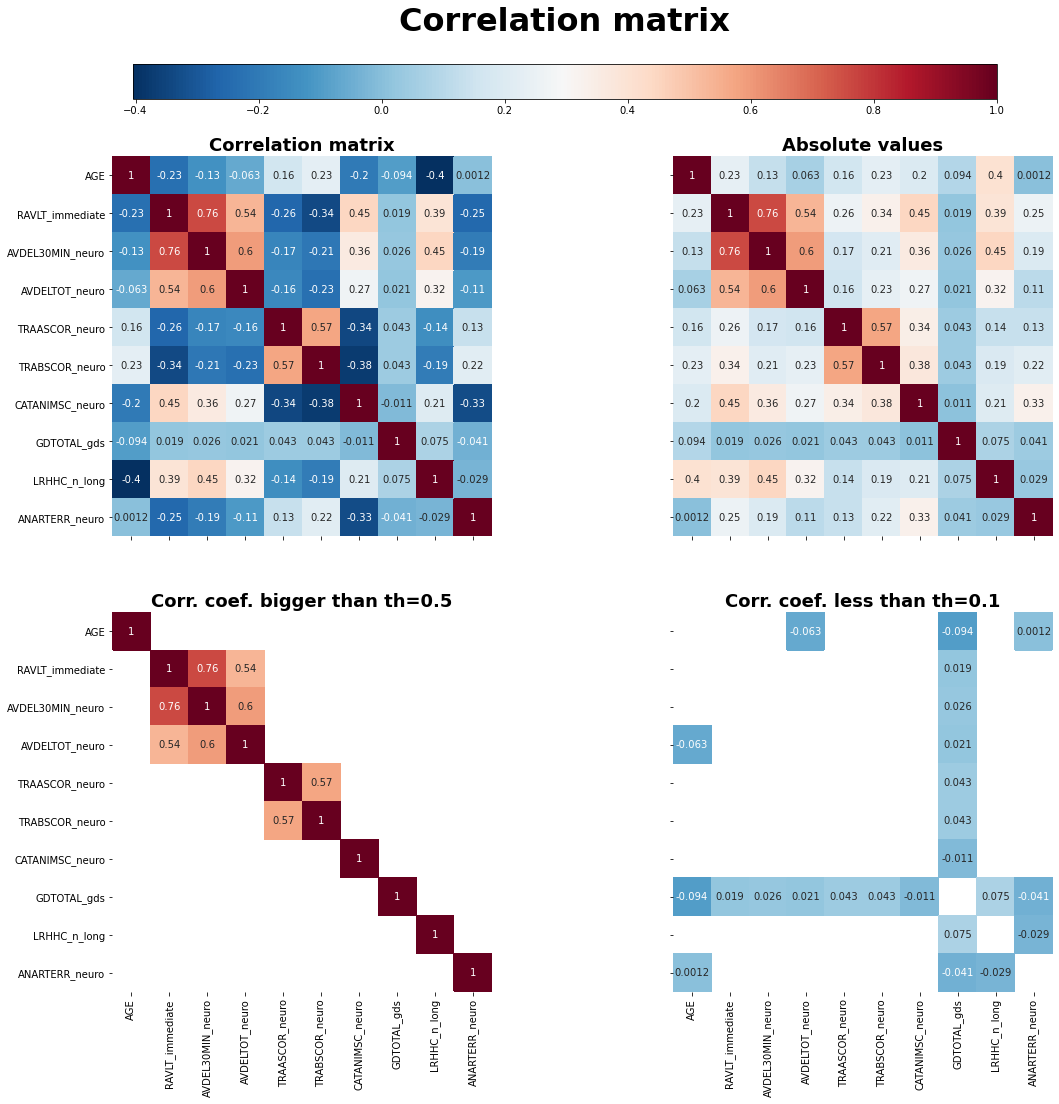

In [32]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

# FEATURE IMPORTANCE (WITH GROUPING)

In [33]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

### PRINT FEATURES (RECAP)

In [34]:
_=[print(c) for c in X_test.columns]

AGE
RAVLT_immediate
AVDEL30MIN_neuro
AVDELTOT_neuro
TRAASCOR_neuro
TRABSCOR_neuro
CATANIMSC_neuro
GDTOTAL_gds
LRHHC_n_long
ANARTERR_neuro


# FEATURE PERMUTATION WITHOUT GROUPING

In [35]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

In [36]:
#?mperm.shuffle_features_with_groups

## SINGLE PERMUTATION

Repetition(s) = 2
Single permutation mode
random_state = 42

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0001-shuffle-features.png



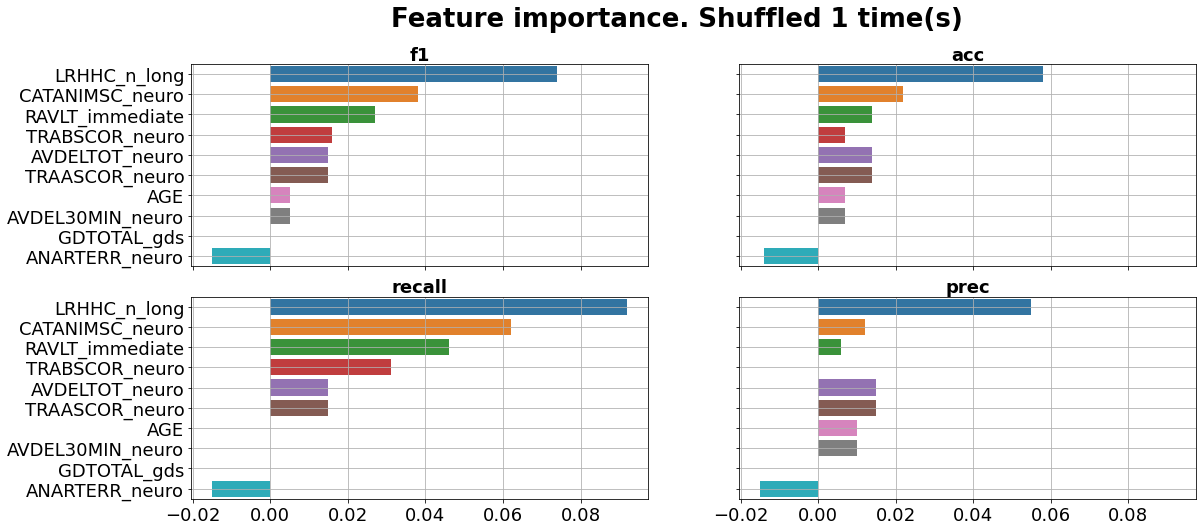

Repetition(s) = 2
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0002-shuffle-features.png



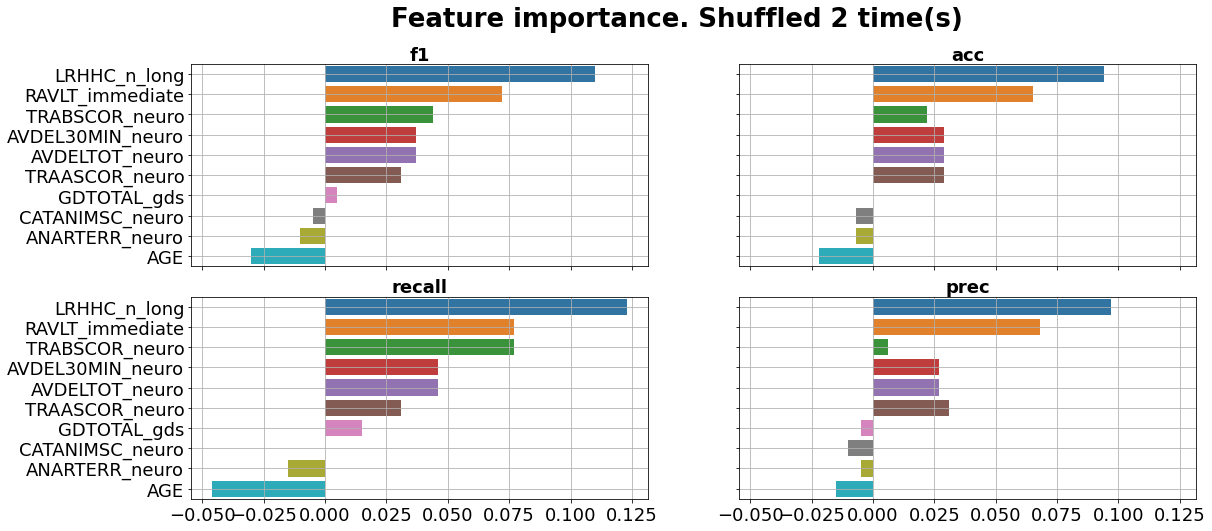

Repetition(s) = 5
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0005-shuffle-features.png



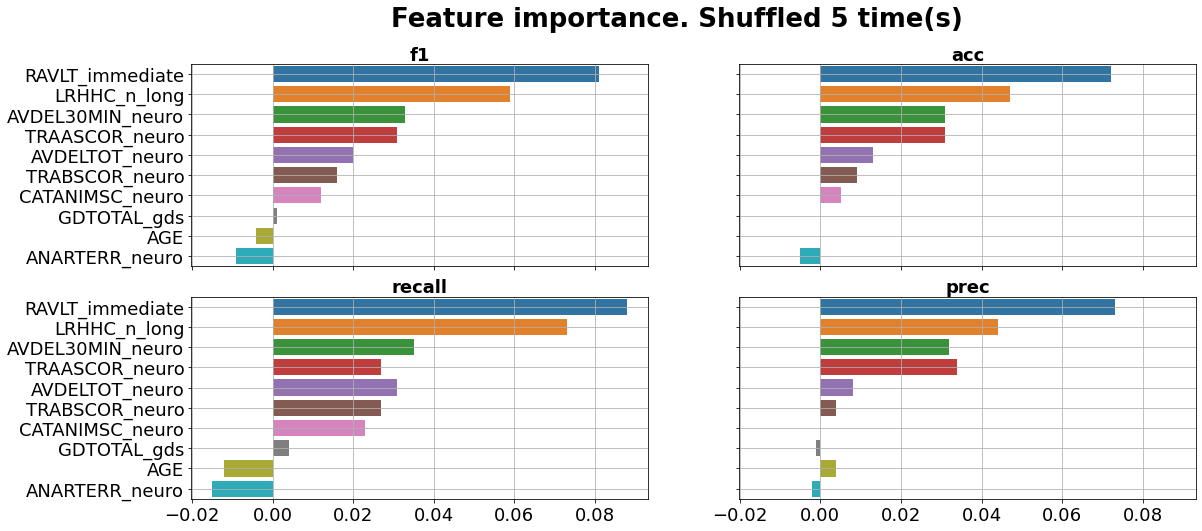

Repetition(s) = 10
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0010-shuffle-features.png



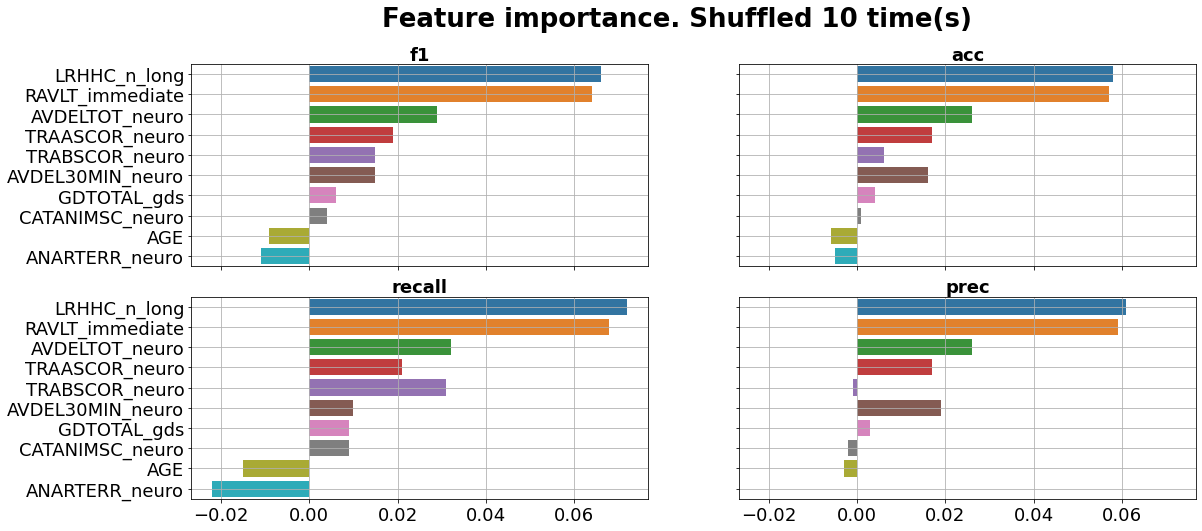

Repetition(s) = 100
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0100-shuffle-features.png



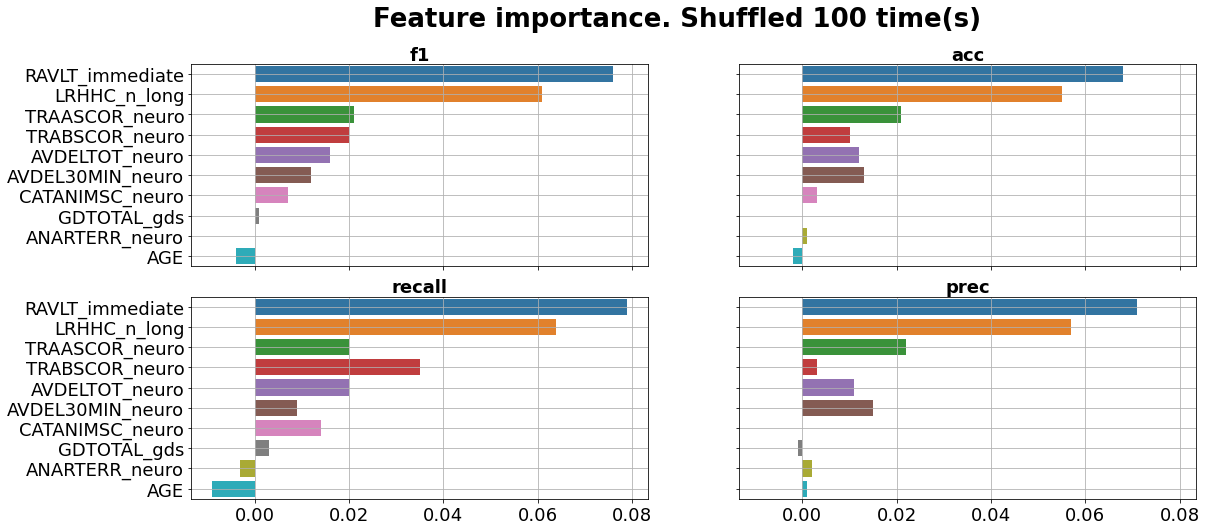

Repetition(s) = 200
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0200-shuffle-features.png



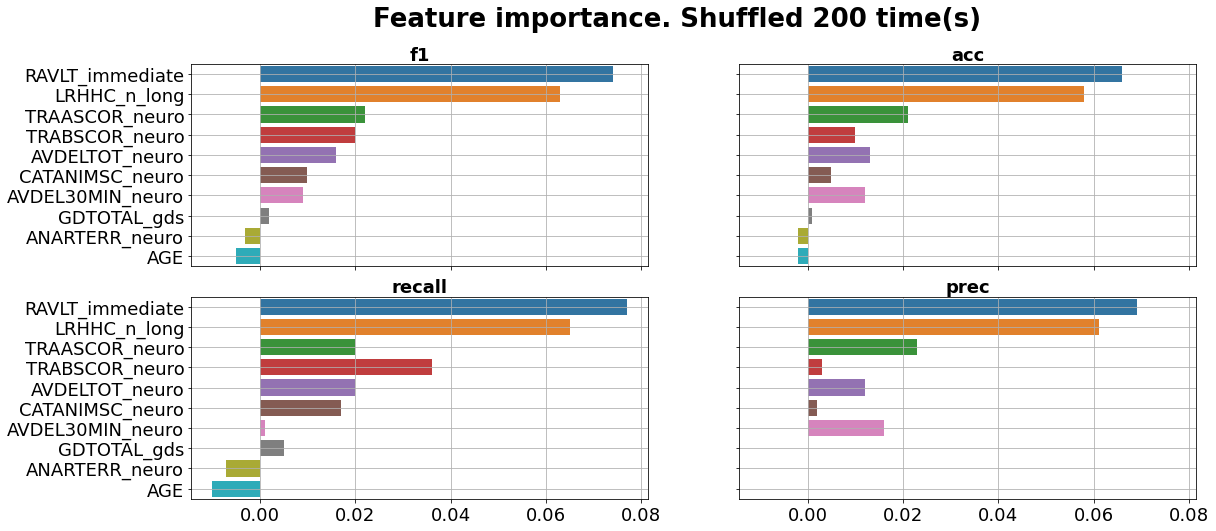

Repetition(s) = 500
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-0500-shuffle-features.png



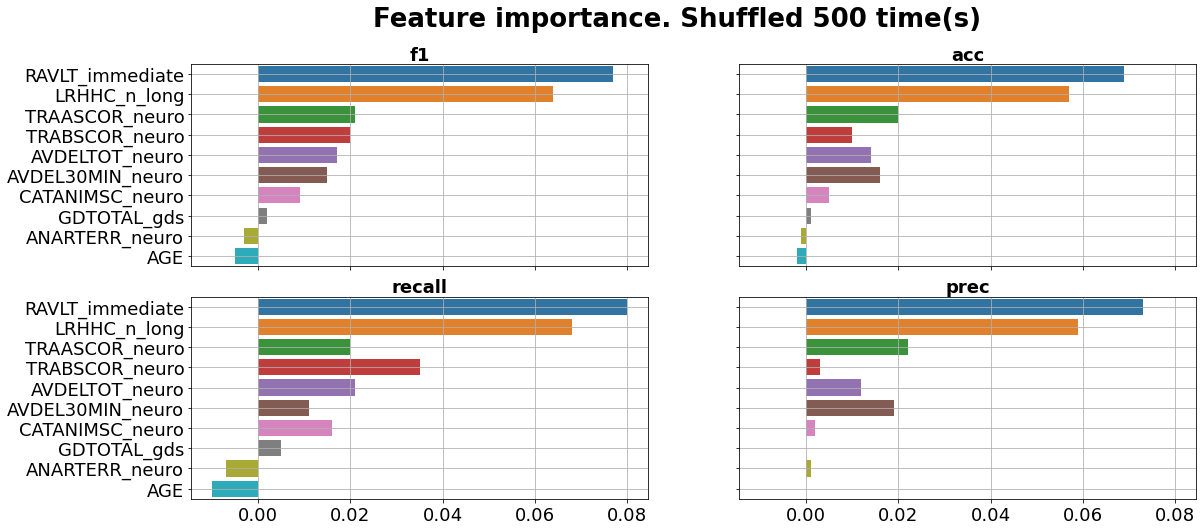

Repetition(s) = 1000
Averaging mode!
random_state = None

Shuffle [group] feature(s) saved to:
		/Users/ingridrye/123/results/20210420/3.02_RF-bl-permutation-reps-1000-shuffle-features.png



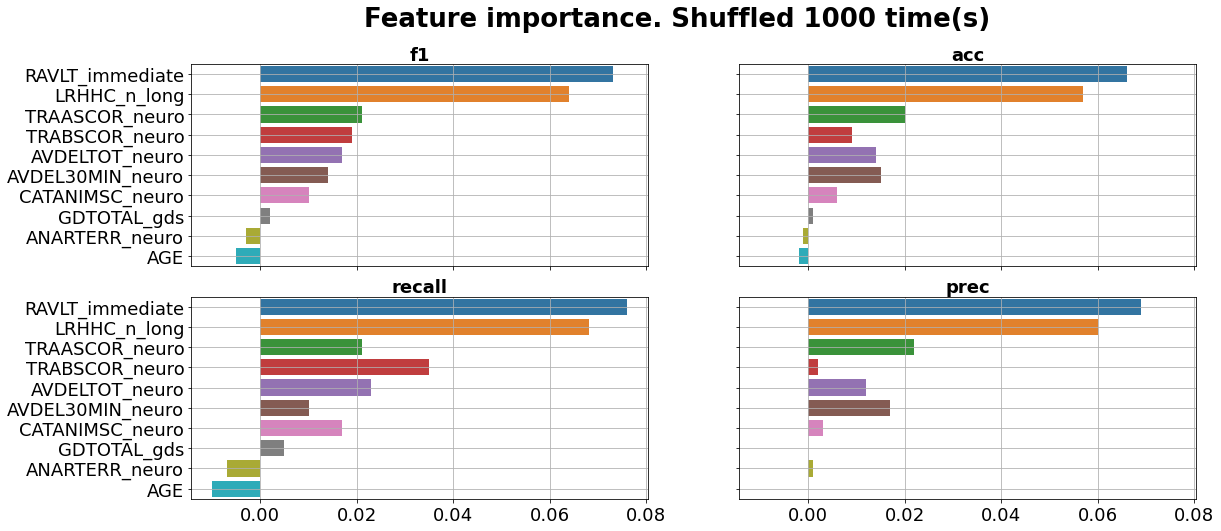

Repetition(s) = 1500
Averaging mode!
random_state = None



In [ ]:
for rep in [0, 1, 4, 9, 99, 199, 499, 999, 1499]:
    df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                      precission=3,
                                                      verbose=False,
                                                      random_state=RANDOM_STATE, # only for repetitions=0
                                                      groups=[],
                                                      repetitions=rep,
                                                      sortBy='f1',
                                                      ascending=False)
    #display(df)
    mperm.plot_permuted_features(df,
                                 file_name_prefix=f'{FILE_NAME_PREFIX}-reps-{rep+1:0>4}',
                                 type='shuffle',
                                 title_suffix=f'Shuffled {rep+1} time(s)',
                                 save=True,
                                 results_dir=RESULTS_DIR,
                                 figsize=(18,8)                             
                                )

---

# FEATURE PERMUTATION WITH GROUPS

In [ ]:
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=200,
                                                  sortBy='f1',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 200 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

---

# DROP SINGLE FEATURE(S)

In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)

In [ ]:
df, features = mperm.dropcol_importances(clf, X_train, y_train, X_test, y_test, random_state=RANDOM_STATE, verbose=False, groups=[])
display(df)
mperm.plot_permuted_features(df, file_name_prefix=FILE_NAME_PREFIX, type='drop', save=True, results_dir=RESULTS_DIR)
mperm._print_group_names(features)

# DROP GROUP OF FEATURES

In [ ]:
df, features = mperm.dropcol_importances(clf, X_train, y_train, X_test, y_test, precission=2, verbose=True, 
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df, file_name_prefix=FILE_NAME_PREFIX, type='drop', save=True, results_dir=RESULTS_DIR)
mperm._print_group_names(features)

---

# 2021.09.14

# GROUPS IN A FOR LOOP

group 0:

['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'LRHHC_n_long']


,f1,acc,recall,prec
Group_0,0.1743,0.1714,0.1538,0.1955
AGE,0.0064,0.0143,-0.0154,0.0288
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
FAQ,0.0575,0.0571,0.0462,0.0696
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



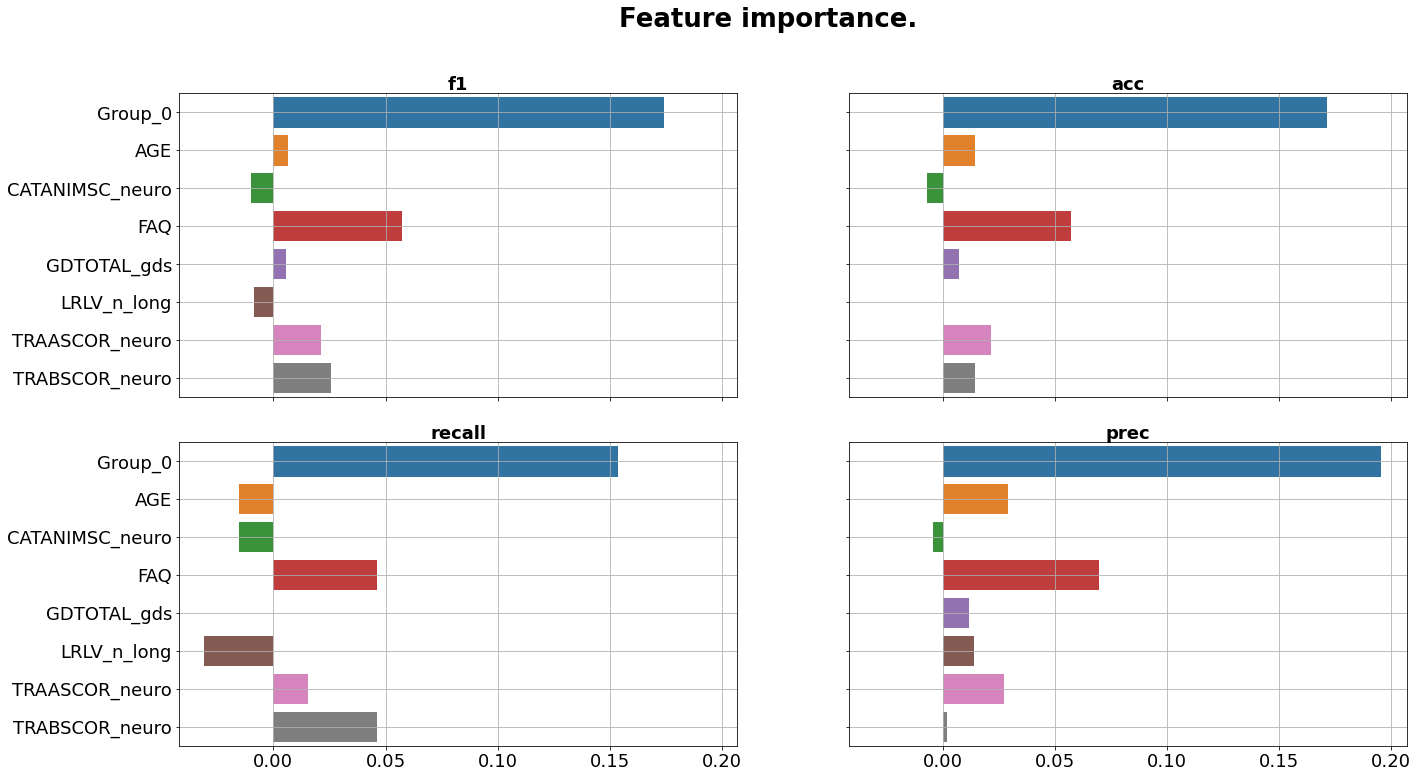

Group_0:['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'LRHHC_n_long']

group 1:

['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'FAQ']


,f1,acc,recall,prec
Group_0,0.1057,0.1214,0.0615,0.1483
AGE,0.0064,0.0143,-0.0154,0.0288
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



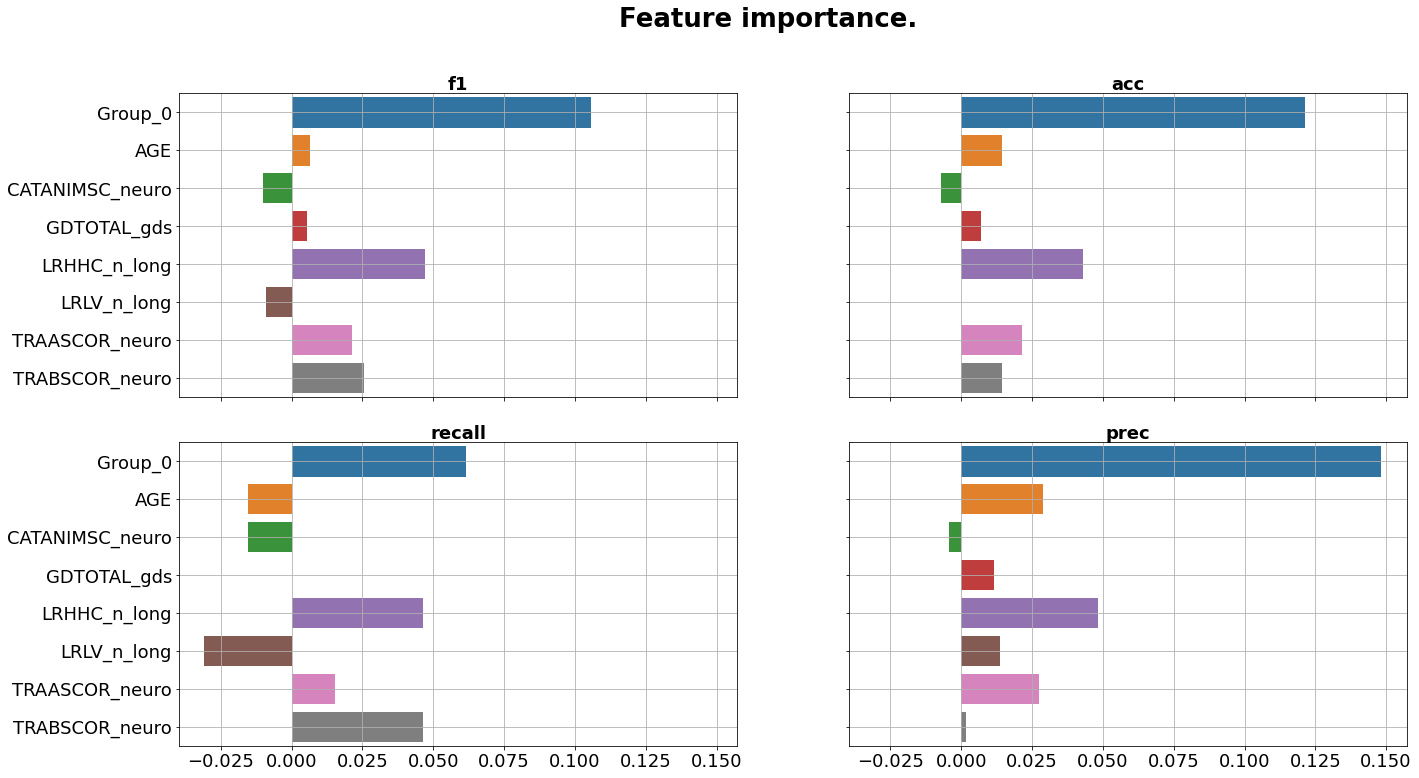

Group_0:['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'FAQ']

group 2:

['LRHHC_n_long', 'FAQ']


,f1,acc,recall,prec
Group_0,0.1285,0.1286,0.1077,0.1500
AGE,0.0064,0.0143,-0.0154,0.0288
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



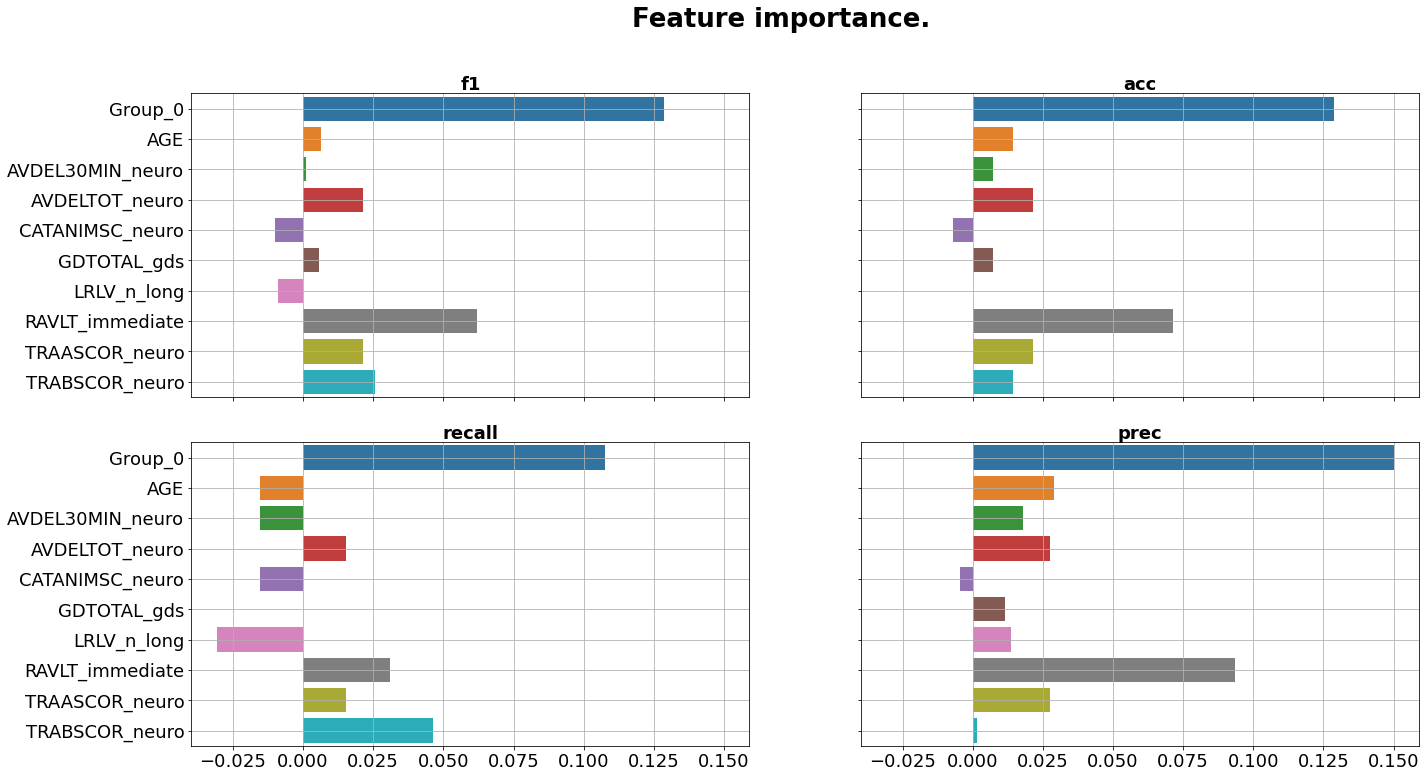

Group_0:['LRHHC_n_long', 'FAQ']

group 3:

['TRAASCOR_neuro', 'TRABSCOR_neuro', 'FAQ']


,f1,acc,recall,prec
Group_0,0.0575,0.0571,0.0462,0.0696
AGE,0.0064,0.0143,-0.0154,0.0288
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



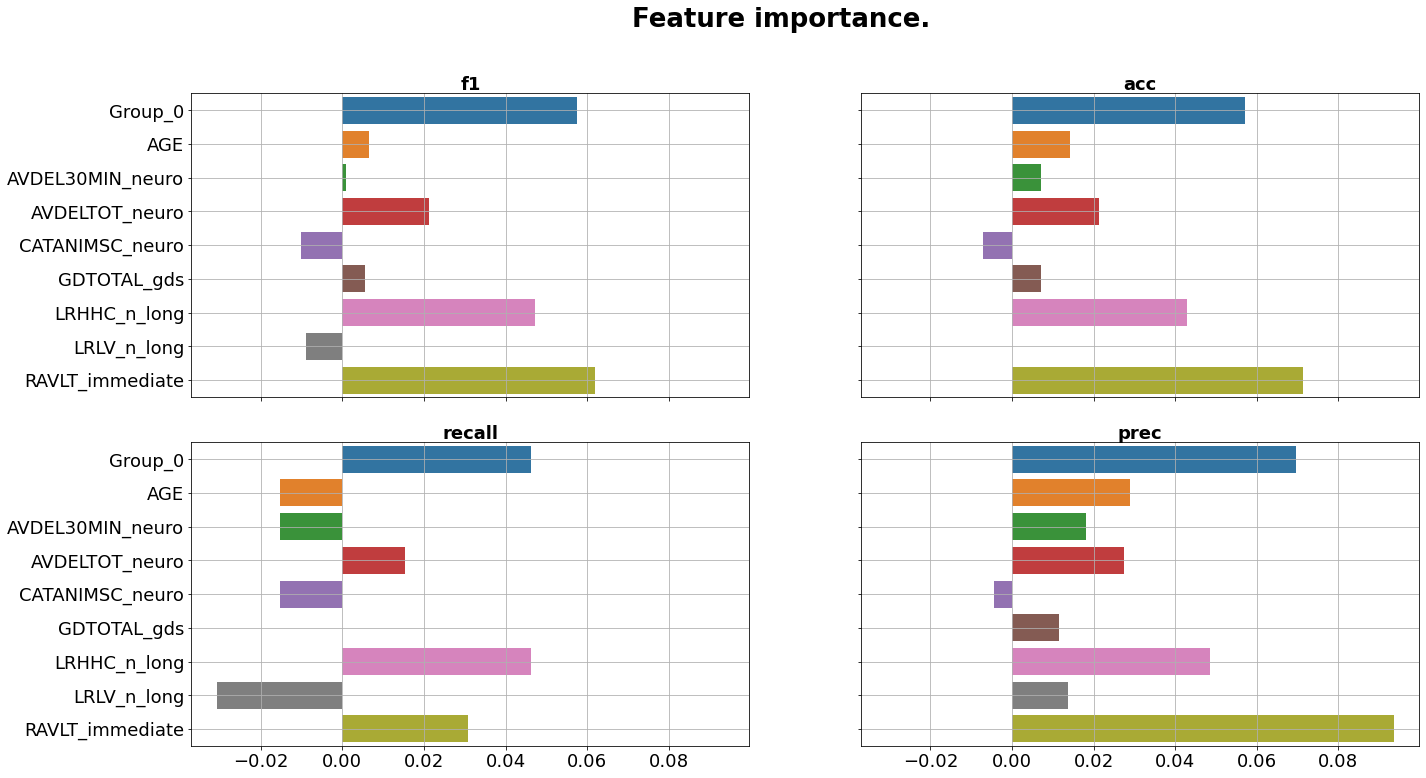

Group_0:['TRAASCOR_neuro', 'TRABSCOR_neuro', 'FAQ']

group 4:

['GDTOTAL_gds', 'FAQ']


,f1,acc,recall,prec
Group_0,0.0837,0.0786,0.0769,0.0909
AGE,0.0064,0.0143,-0.0154,0.0288
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



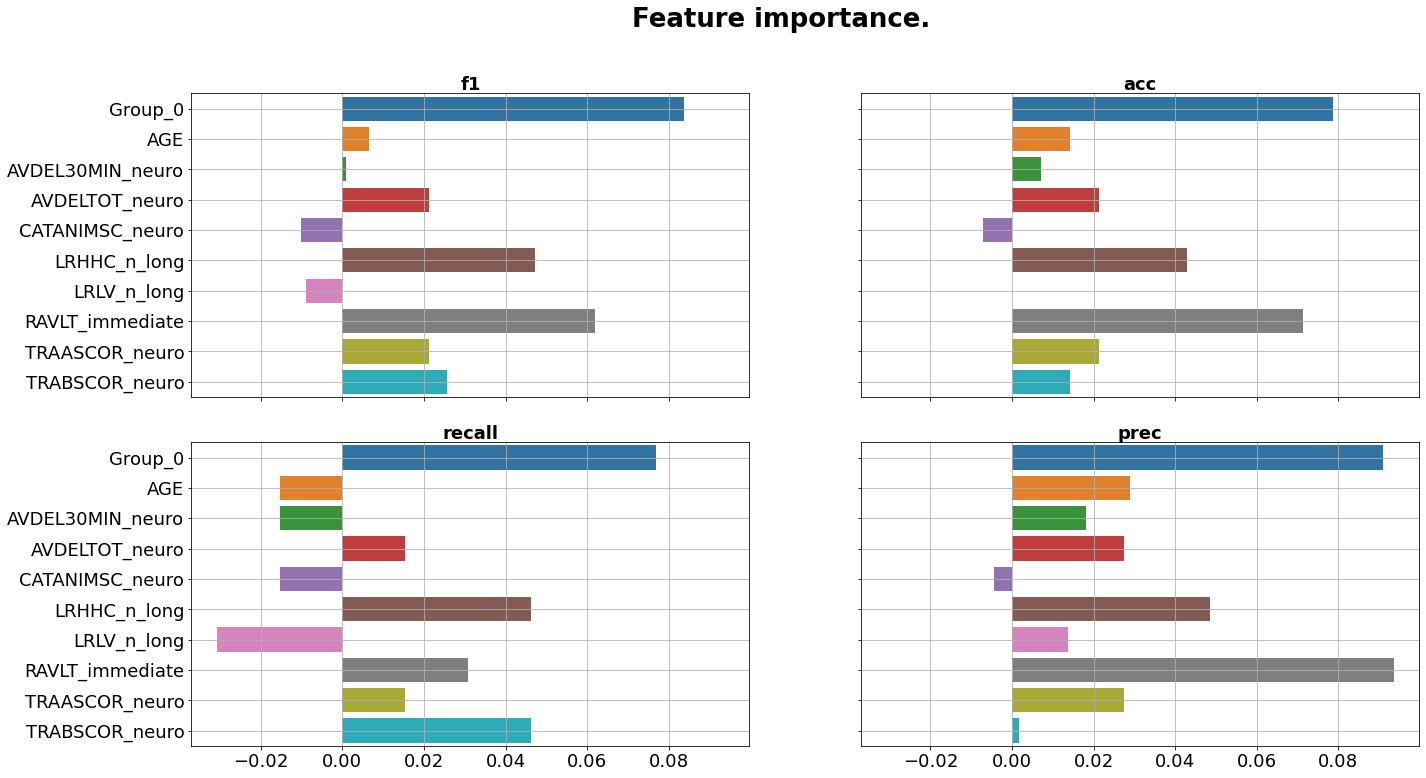

Group_0:['GDTOTAL_gds', 'FAQ']

group 5:

['LRLV_n_long', 'FAQ']


,f1,acc,recall,prec
Group_0,0.0317,0.0357,0.0154,0.0489
AGE,0.0064,0.0143,-0.0154,0.0288
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



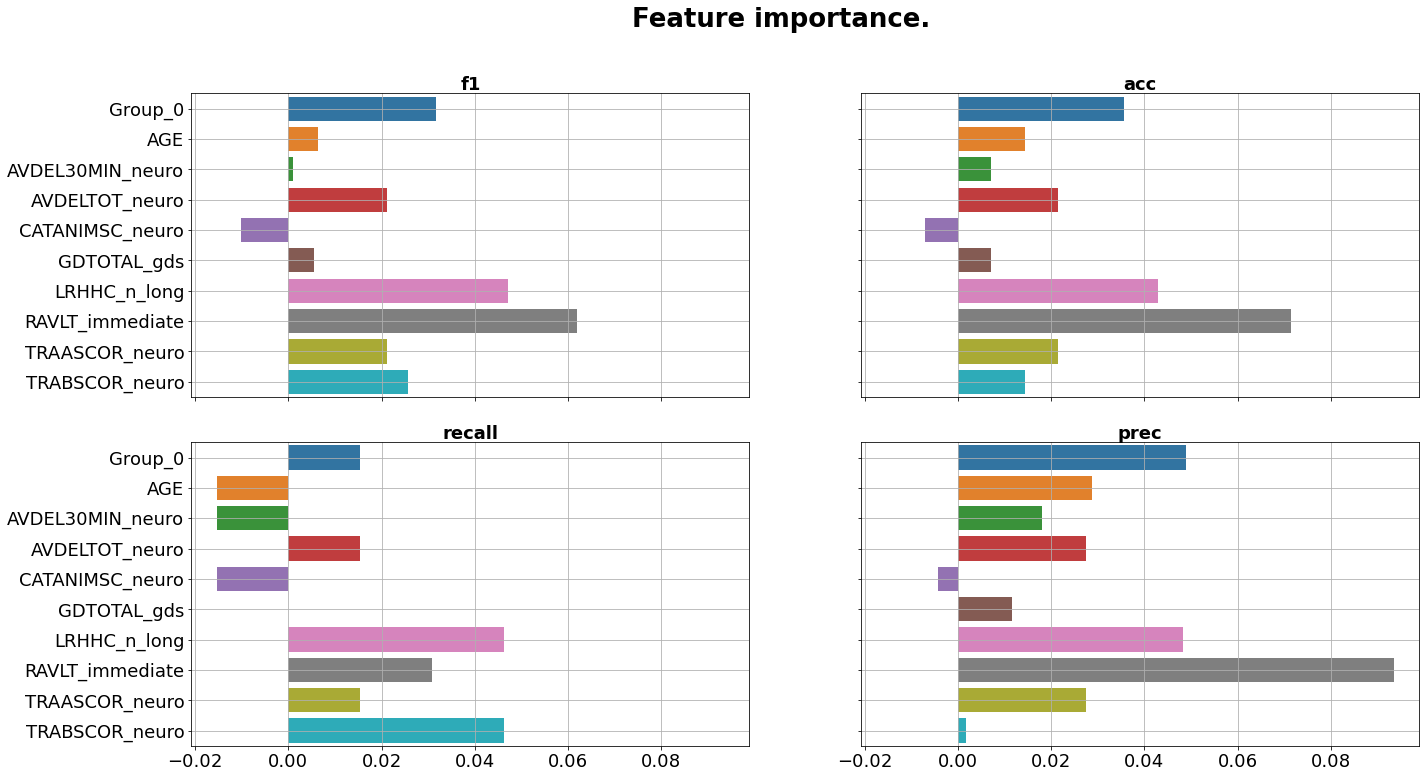

Group_0:['LRLV_n_long', 'FAQ']

group 6:

['CATANIMSC_neuro', 'FAQ']


,f1,acc,recall,prec
Group_0,0.0779,0.0786,0.0615,0.0950
AGE,0.0064,0.0143,-0.0154,0.0288
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



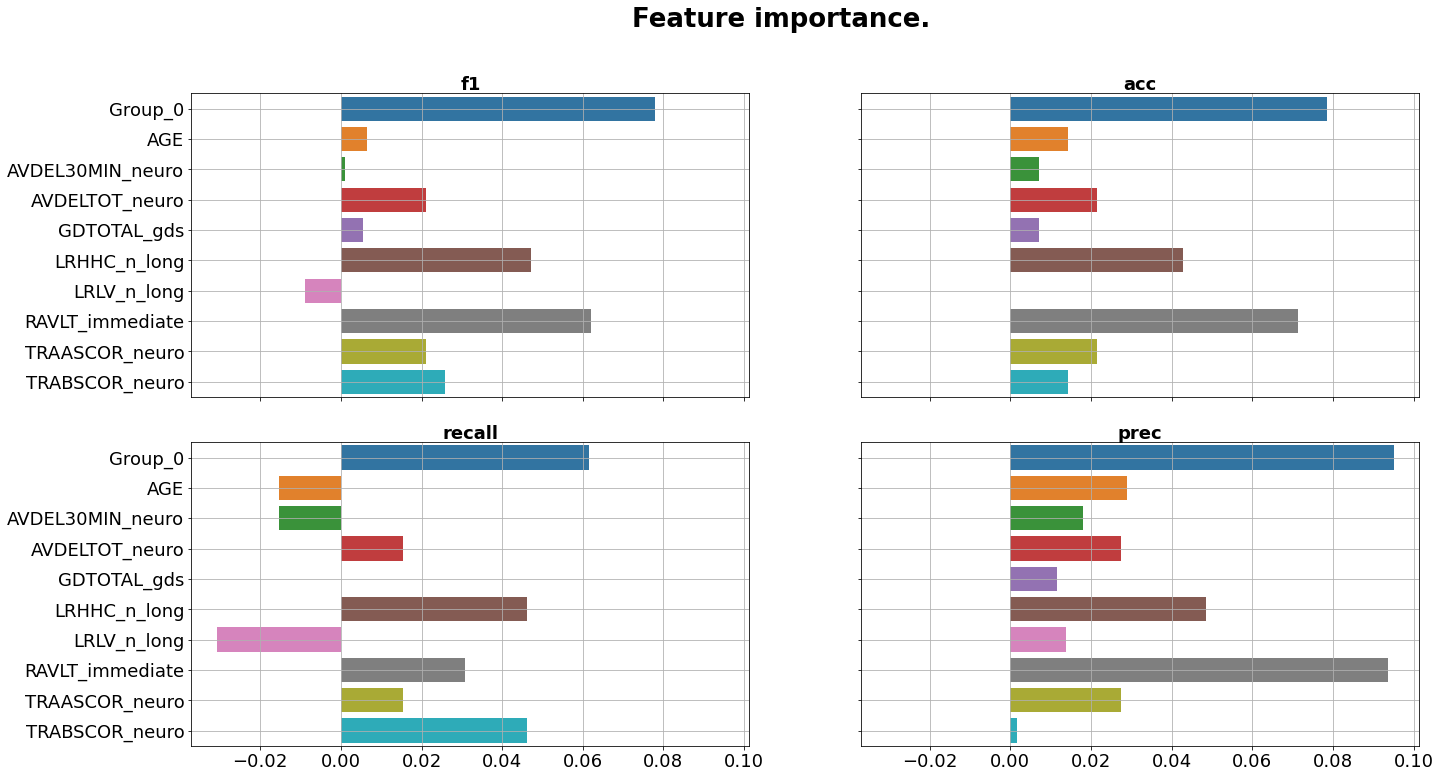

Group_0:['CATANIMSC_neuro', 'FAQ']

group 7:

['AGE', 'FAQ']


,f1,acc,recall,prec
Group_0,0.0779,0.0786,0.0615,0.0950
AVDEL30MIN_neuro,0.0010,0.0071,-0.0154,0.0181
AVDELTOT_neuro,0.0212,0.0214,0.0154,0.0274
CATANIMSC_neuro,-0.0101,-0.0071,-0.0154,-0.0044
GDTOTAL_gds,0.0055,0.0071,0.0000,0.0115
LRHHC_n_long,0.0472,0.0429,0.0462,0.0484
LRLV_n_long,-0.0089,0.0000,-0.0308,0.0137
RAVLT_immediate,0.0620,0.0714,0.0308,0.0935
TRAASCOR_neuro,0.0212,0.0214,0.0154,0.0274
TRABSCOR_neuro,0.0257,0.0143,0.0462,0.0017


Shuffle [group] feature(s) saved to:
		/data-10tb/marek/github_codes/MCI-subgroups/results/20210420/3.02_RF-bl-permutation-drop-features.png



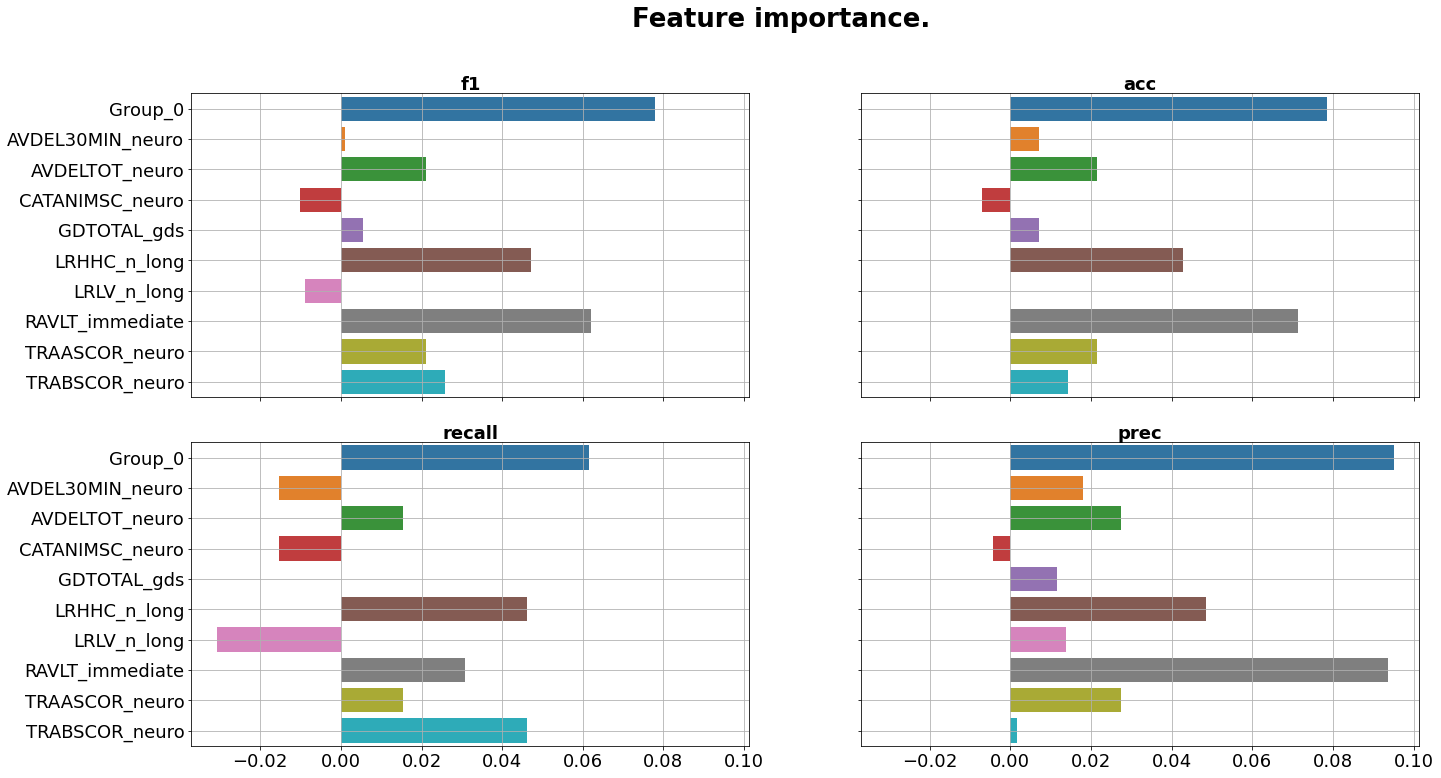

Group_0:['AGE', 'FAQ']



In [108]:
groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'LRHHC_n_long'],
                                                          ['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'FAQ'],
                                                          ['LRHHC_n_long','FAQ'],
                                                          ['TRAASCOR_neuro', 'TRABSCOR_neuro', 'FAQ'],
                                                          ['GDTOTAL_gds', 'FAQ'],
                                                          ['LRLV_n_long', 'FAQ'],
                                                          ['CATANIMSC_neuro', 'FAQ'],
                                                          ['AGE', 'FAQ']
                                                         ]
for k, gr in enumerate(groups):
    print(f'group {k}:\n')
    print(gr)
    df, features = mperm.dropcol_importances(clf, X_train, y_train, X_test, y_test, precission=4, verbose=False, 
                                                      groups=[gr])
    display(df)
    mperm.plot_permuted_features(df, file_name_prefix=FILE_NAME_PREFIX, type='drop', save=True, results_dir=RESULTS_DIR)
    mperm._print_group_names(features)
    print(f'\n{80*"="}')

---